In [1]:
import os
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.chdir("C:\\Users\\EVandewalle\\Documents\\Libcitations_2")

## Similarity between catalogs

For the UniCat dataset, we have catalogs that are quite different in size, but also in type of collection. The national library, university libraries, but also museum libraries and heritage libraries. This is why it could be interesting to map the libraries according to how similar their collections are. Torres-Salinas and Moed(2009) have used the Salton's index for calculating the similarity between catalogues based on how many books they hold in common and then Multidimensional Scaling (MDS) to map the libraries in a two-dimensional plot. 

We also have information on the library types, so we could see if libraries of the same type appear to be more similar.

### Importing data

In [3]:
con = sqlite3.connect("new_unicat.db")

In [4]:
holding = pd.read_sql("""SELECT work_id, location FROM holding""", con)

In [5]:
holding = holding.drop_duplicates().copy()

In [6]:
library_types = pd.read_sql("""SELECT library, type FROM libraries""", con)

### Calculating Salton's index

Calculating the Salton Index as found in Torres-Salinas and Moed (2009) for showing the similarity between catalogs.

The Salton's index is calculated by:

* The number of titles the catalogs have in common divided by the square root of the product of the number of titles in each catalog

In [7]:
holding.shape

(149398, 2)

In [8]:
list_libraries = holding.location.unique()
len(list_libraries)

78

In [9]:
from itertools import combinations

def common_titles(df):
    """Requires a dataframe with a column 'work-id' and a column 'location'
    Also requires itertools
    Returns a dataframe with library combinations and the number of times the combination occurs """
    # group by work-id and create a set of locations for each work-id
    sets = df.groupby("work_id").location.agg(set)
    # find all possible combinations (in pairs of two) for each of the sets
    sets = sets.apply(lambda x: combinations(sorted(x), 2))
    # turn the combinations into a list
    list_combinations = sets.apply(lambda x: list(x))
    # explode the list of combinations so that each line represents a combination
    list_combinations_exploded = list_combinations.explode()
    # create a dataframe and group by the location combinations to get the number of times the locations occur together
    grouped_df = pd.DataFrame(list_combinations_exploded).reset_index()
    grouped_df = pd.DataFrame(grouped_df.groupby("location").work_id.count()).reset_index()
    ## add each of the locations to the dataframe
    grouped_df["lib1"] = grouped_df.location.apply(lambda x: x[0])
    grouped_df["lib2"] = grouped_df.location.apply(lambda x: x[1])
    return grouped_df

In [10]:
df = common_titles(holding)
df.head(5)

,location,work_id,lib1,lib2
0,"(AB-Tongerlo, AMSAB)",2,AB-Tongerlo,AMSAB
1,"(AB-Tongerlo, AP)",5,AB-Tongerlo,AP
2,"(AB-Tongerlo, ARB)",2,AB-Tongerlo,ARB
3,"(AB-Tongerlo, Arteveldehogeschool)",15,AB-Tongerlo,Arteveldehogeschool
4,"(AB-Tongerlo, Belgian Parliament)",8,AB-Tongerlo,Belgian Parliament


In [11]:
# total number of each of the libraries
totals = holding.groupby("location").count().reset_index()
totals_dict = dict(zip(totals.location, totals.work_id))

In [12]:
totals_dict

{'AB-Tongerlo': 73,
 'ACV - CSC': 358,
 'AMSAB': 311,
 'AP': 2634,
 'ARB': 361,
 'Arteveldehogeschool': 2429,
 'Belgian Parliament': 2198,
 'Botanic_Garden_Meise': 24,
 'CBB': 8,
 'CaGeWeB': 1113,
 'DAN': 4,
 'DB': 803,
 'DmG': 17,
 'DocAtlas': 14,
 'EHC': 4185,
 'EhB': 747,
 'FARO': 404,
 'FOD Finances': 1417,
 'FOD/SPF PO': 263,
 'Groot Seminarie Brugge': 436,
 'Groot Seminarie Gent': 382,
 'HH-EVA': 46,
 'HZS': 12,
 'Hogeschool Gent': 2526,
 'Hogeschool West-Vlaanderen': 1717,
 'Huis van Alijn': 123,
 'IMEC': 5,
 'IPIS': 38,
 'KADOC': 930,
 'KAVA': 4,
 'KBC': 1503,
 'KBR': 11738,
 'KCE': 70,
 'KDG': 2976,
 'KMSKA': 615,
 'KU Leuven': 15959,
 'LUCA School of Arts': 3473,
 'Letterenhuis': 107,
 'Liberas (Liberaal Archief)': 932,
 'MAS': 100,
 'MMB': 66,
 'MPM': 241,
 'MSK': 222,
 'Middelheim': 133,
 'Musée royal de Mariemont': 193,
 'NATO': 75,
 'National Bank of Belgium': 1280,
 'Odisee': 6153,
 'PXL': 1061,
 'RSL': 46,
 'RoSa': 169,
 'Royal Belgian Institute for Natural Sciences': 1

In [13]:
df["lib1_total"]=df.lib1.apply(lambda x: totals_dict[x])

In [14]:
df["lib2_total"]=df.lib2.apply(lambda x: totals_dict[x])

In [15]:
df["Salton"] = df["work_id"]/(np.sqrt(df["lib1_total"]*df["lib2_total"]))

In [16]:
df["location"] = df.location.apply(frozenset)

In [17]:
df.sort_values(by="Salton", ascending=False)

,location,work_id,lib1,lib2,lib1_total,lib2_total,Salton
2388,"(Thomas More Kempen, Thomas More Mechelen)",3372,Thomas More Kempen,Thomas More Mechelen,4124,3880,0.842970
2401,"(Thomas More Kempen, VIVES)",3800,Thomas More Kempen,VIVES,4124,5110,0.827778
2459,"(UCLL, VIVES)",4316,UCLL,VIVES,5342,5110,0.826074
2391,"(Thomas More Kempen, UCLL)",3830,Thomas More Kempen,UCLL,4124,5342,0.815995
2417,"(VIVES, Thomas More Mechelen)",3555,Thomas More Mechelen,VIVES,3880,5110,0.798387
...,...,...,...,...,...,...,...
1513,"(KBC, MPM)",1,KBC,MPM,1503,241,0.001662
997,"(Rubenianum, FOD Finances)",1,FOD Finances,Rubenianum,1417,326,0.001471
967,"(Groot Seminarie Gent, FOD Finances)",1,FOD Finances,Groot Seminarie Gent,1417,382,0.001359
286,"(ARB, KBC)",1,ARB,KBC,361,1503,0.001358


## Plot with networkX

In [18]:
import networkx as nx

In [19]:
dict_salton = dict(zip(df.location, df.Salton))

In [20]:
list_of_lists = [[dict_salton[frozenset([lib2,lib1])] if frozenset([lib2,lib1]) in dict_salton else 1 if lib1==lib2 else 0 for lib1 in list_libraries] for lib2 in list_libraries]

In [21]:
similarity_matrix = np.array(list_of_lists)

In [22]:
G = nx.to_networkx_graph(similarity_matrix)

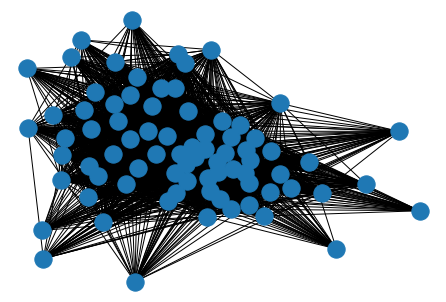

In [23]:
nx.draw(G)

In [24]:
# create a graph
G = nx.Graph()

In [25]:
# add nodes
G.add_nodes_from(list_libraries)

In [26]:
# add edges
G.add_edges_from(df.location)

In [27]:
tuple_weights = tuple(zip(df.lib1,df.lib2,df.Salton))

In [28]:
G.add_weighted_edges_from(tuple_weights)

### create a plot with these positions

In [31]:
pos = nx.spring_layout(G)

In [32]:
positions = list(pos.values())

In [33]:
positions = pd.DataFrame(positions).rename(columns={0:"x",1:"y"})

In [34]:
positions["library"] = list_libraries

In [35]:
positions = positions.merge(library_types, on="library").copy()

In [36]:
positions["size"] = positions.library.apply(lambda x: totals_dict[x])

In [37]:
from adjustText import adjust_text

In [40]:
# using color palette because we want to use the same colors for the barplot
library_types = positions.type.unique()
palette = dict(zip(library_types, sns.color_palette(n_colors=len(library_types))))

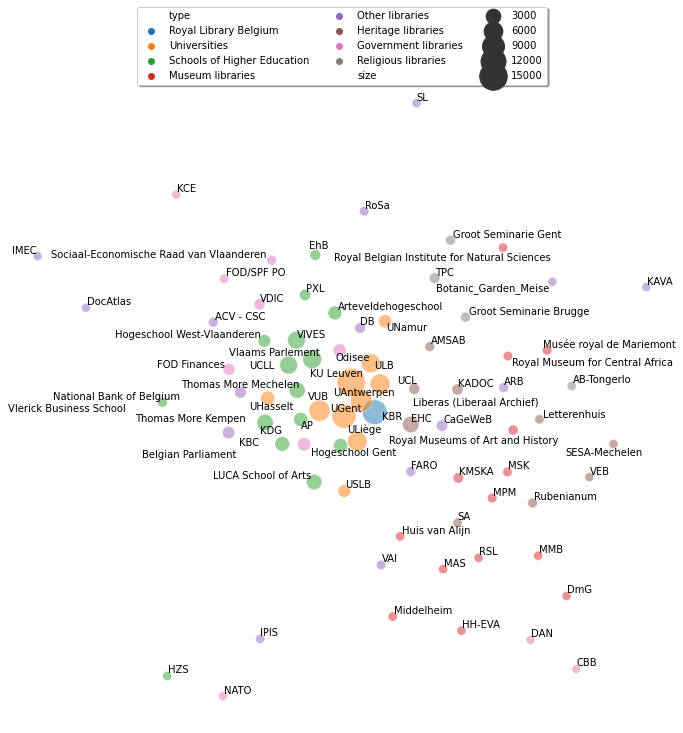

In [42]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(data = positions, x="x", y="y", hue = "type", size="size", sizes=(80, 800), alpha = .5, palette=palette, ax=ax)
libraries = positions.library

texts = [plt.text(positions.x[i], positions.y[i], lib) for i,lib in enumerate(libraries)]

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11),
          ncol=3, fancybox=True, shadow=True)

adjust_text(texts)

plt.axis("off")

plt.savefig("plots/library_catalogue_plot.png")

# Overview of UniCat libraries

In [43]:
db_con = sqlite3.connect("new_unicat.db")

In [44]:
df = pd.read_sql(
            """
            SELECT work_id, location, library, type
            FROM 
            holding h
            JOIN libraries l on h.location = l.library""", db_con)

In [45]:
# the table shows how many works were found in each of the libraries in the dataset
library_table = pd.DataFrame(df.library.value_counts()).reset_index().rename(columns={'index':'library', "library":'count'})
library_table.head(10)

,library,count
0,KU Leuven,18731
1,KBR,13067
2,UGent,12382
3,VUB,9319
4,UAntwerpen,9091
5,ULiège,7873
6,UCL,7471
7,Odisee,6547
8,ULB,6497
9,UCLL,5722


In [46]:
type_table = pd.DataFrame(df.type.value_counts()).reset_index().rename(columns={'index':'type', "type":'count'})
type_table

,type,count
0,Universities,78390
1,Schools of Higher Education,47282
2,Royal Library Belgium,13067
3,Government libraries,8270
4,Heritage libraries,7356
5,Other libraries,7212
6,Museum libraries,2745
7,Religious libraries,1642


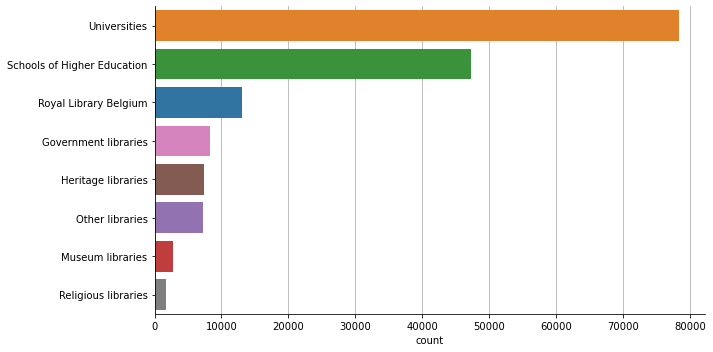

In [47]:
fig, ax = plt.subplots(figsize=(10,5))

# plot the data
sns.barplot(data = type_table.head(10), x="count", y="type",palette=palette, ax=ax)

#add grid, remove border
ax.grid(axis="x")
ax.set_axisbelow(True)
sns.despine(right=True)

#changeaxis labels
ax.set_ylabel("")

plt.tight_layout()

plt.savefig("plots/library_types.png")